In [1]:
# In order to have a reference line, a base model will be trained with face cropped and aligned for bonafide vs printed vs screen classes (3 classes).
# - obj: train over FLICKR and eval with FLICKR

# take json files and gather data to training format -> bonafide vs imposter

In [2]:
import os
import json
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from augmentations import avg_aug

from tensorflow.keras.metrics import FalsePositives, FalseNegatives, AUC, TruePositives, TrueNegatives

%load_ext autoreload
%autoreload 2

In [3]:
datapath = '../data/02_intermediate/flickr'
images_list = [*list_images(datapath)]
_classes = ('attack', 'bonafide')
_bf_index = _classes.index('bonafide')

## Variables

In [4]:
alpha = 1.0
epochs = 200
batch_size = 16
_size = (448, 448)
learning_rate = 1e-4
buffer_size = 10101101
optim_str = 'rmsprop' # rmsprop / sgd / adam
output_func = 'sigmoid' # sigmoid / softmax
loss = 'binary_crossentropy' # binary_crossentropy / categorical_crossentropy


bf, att = [], []

for imdir in images_list:
    if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
        bf.append(imdir)
    else:
        att.append(imdir)

In [5]:
len(bf), len(att)

(3000, 10975)

In [6]:
def _parse_function_with_DA(impath):
    # instantiate augmentation here to overcome "not-changing-random-seed" bug
    # this could lead to an speed decrease or an overheap, dont know
    aug = avg_aug() # think about deleting aug after use
    
    # image reading
    image = tf.io.read_file(impath)
    image = tf.io.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, _size)
    image = tf.cast(image, tf.uint8)
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    # image = tf.clip_by_value(image, -1, 1)
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, lb

def _parse_function_without_DA(impath):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, _size)
    image = image / 255.
    
    # image = tf.clip_by_value(image, -1, 1)
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, lb

# How to make dataset

In [7]:
# def train, test, val sets # done

In [8]:
bf_y = np.ones(len(bf))
att_y = np.zeros(len(att))

# limit data
att = att[:len(bf)*2]
att_y = att_y[:len(bf)*2]

In [9]:
bf_y.shape, att_y.shape

((3000,), (6000,))

In [10]:
X = np.concatenate([bf, att])
y = np.concatenate([bf_y, att_y])

In [11]:
# store this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [12]:
np.unique(y_train, return_counts=True), np.unique(y_val, return_counts=True), np.unique(y_test, return_counts=True)

((array([0., 1.]), array([3595, 1805])),
 (array([0., 1.]), array([1204,  596])),
 (array([0., 1.]), array([1201,  599])))

In [13]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [14]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.7510431154381085, 1: 1.4958448753462603}

# Train data

In [15]:
train_dataset = tf.cast(X_train, dtype=tf.string)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.map(_parse_function_with_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size)

2022-11-30 06:18:55.435660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:18:55.436053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:18:55.460383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:18:55.460794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:18:55.461456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

# Val data

In [16]:
val_dataset = tf.cast(X_val, dtype=tf.string)
val_dataset = tf.data.Dataset.from_tensor_slices(val_dataset)
val_dataset = val_dataset.shuffle(buffer_size)
val_dataset = val_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(1)

# Test data

In [17]:
test_dataset = tf.cast(X_test, dtype=tf.string)
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.shuffle(11001010)
test_dataset = test_dataset.map(_parse_function_without_DA)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(1)

In [18]:
len(train_dataset)

338

In [19]:
# for e in range(3):
    
#     i = 0
    
#     for im, lb in iter(train_dataset):
#         if i < 3:
#             _class_argmax = np.argmax(lb[0], axis=-1)
#             plt.title(f'GT label: {_classes[_class_argmax]}')
#             plt.imshow(im[0])
#             plt.show()
#         i += 1
#         # break

In [20]:
# agregar explicacion de pruebas de rostros, con tantas imagenes, recorte con mtcnn, modelo, entre otros. -> linea base
# definir experimento con zona periocular

# terminar jupyter de recorte de marcas manuales de mtcnn

/tmp/ipykernel_4726/690517677.py:2: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


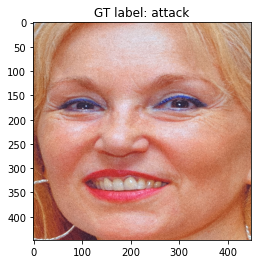

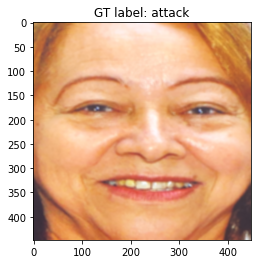

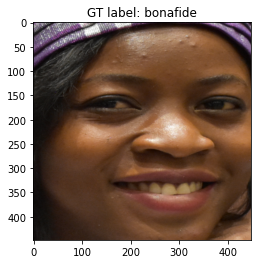

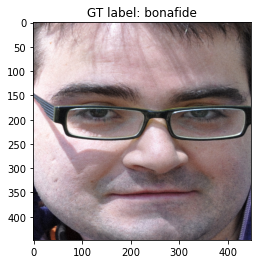

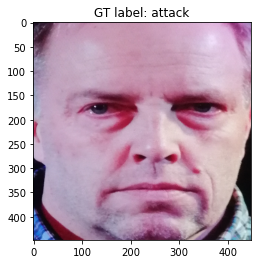

2022-11-30 06:18:59.665008: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
with warnings.catch_warnings():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.simplefilter("ignore")
    
    for bs in train_dataset.take(5):
        im, lb = bs

        _class_argmax = np.argmax(lb[0], axis=-1)
        plt.title(f'GT label: {_classes[_class_argmax]}')
        plt.imshow(im[0])
        plt.show()
        # break

In [22]:
# def model to be trained
# def a sequence of variables to be explored

In [23]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121

In [24]:
input_shape = (*_size, 3) # 224x224x3

model = MobileNetV2(input_shape=input_shape, alpha=alpha, include_top=False, weights=None, pooling='max')
# model = DenseNet121(input_shape=input_shape, include_top=False, pooling='max')

In [25]:
import tensorflow as tf
from math import pi

# ref: https://www.kaggle.com/code/chankhavu/keras-layers-arcface-cosface-adacos/notebook7
# ref: https://github.com/yinguobing/arcface/blob/main/train.py

class L2Normalization(tf.keras.layers.Layer):
    """This layer normalizes the inputs with l2 normalization."""

    def __init__(self, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)

    @tf.function
    def call(self, inputs):
        inputs = tf.nn.l2_normalize(inputs, axis=1)

        return inputs

    def get_config(self):
        config = super().get_config()
        return config

class ArcLayer(tf.keras.layers.Layer):
    """Custom layer for ArcFace.
    This layer is equivalent a dense layer except the weights are normalized.
    """

    def __init__(self, units, kernel_regularizer=None, **kwargs):
        super(ArcLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=[input_shape[-1], self.units],
                                      dtype=tf.float32,
                                      initializer=tf.keras.initializers.HeNormal(),
                                      regularizer=self.kernel_regularizer,
                                      trainable=True,
                                      name='kernel')
        self.built = True

    @tf.function
    def call(self, inputs):
        weights = tf.nn.l2_normalize(self.kernel, axis=0)
        return tf.matmul(inputs, weights)

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units,
                       "kernel_regularizer": self.kernel_regularizer})
        return config

class ArcLoss(tf.keras.losses.Loss):
    """Additive angular margin loss.
    Original implementation: https://github.com/luckycallor/InsightFace-tensorflow
    """

    def __init__(self, margin=0.5, scale=64, name="arcloss"):
        """Build an additive angular margin loss object for Keras model."""
        super().__init__(name=name)
        self.margin = margin
        self.scale = scale
        self.threshold = tf.math.cos(pi - margin)
        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)

        # Safe margin: https://github.com/deepinsight/insightface/issues/108
        self.safe_margin = self.sin_m * margin

    @tf.function
    def call(self, y_true, y_pred):

        # Calculate the cosine value of theta + margin.
        cos_t = y_pred
        sin_t = tf.math.sqrt(1 - tf.math.square(cos_t))

        cos_t_margin = tf.where(cos_t > self.threshold,
                                cos_t * self.cos_m - sin_t * self.sin_m,
                                cos_t - self.safe_margin)

        # The labels here had already been onehot encoded.
        mask = y_true
        cos_t_onehot = cos_t * mask
        cos_t_margin_onehot = cos_t_margin * mask

        # Calculate the final scaled logits.
        logits = (cos_t + cos_t_margin_onehot - cos_t_onehot) * self.scale

        losses = tf.nn.softmax_cross_entropy_with_logits(y_true, logits)

        return losses

    def get_config(self):
        config = super(ArcLoss, self).get_config()
        config.update({"margin": self.margin, "scale": self.scale})
        return config

In [26]:
# reg = tf.keras.regularizers.L2(1e-4)

# x = model.output
# x = L2Normalization()(x)
# x = ArcLayer(2, reg)(x)
# loss = ArcLoss()
# # x = Dense(units=2, activation=output_func, use_bias=True, name="Logits")(x)

# model = Model(inputs=model.input, outputs=x)

In [27]:
x = model.output
x = Dense(units=2, activation=output_func, use_bias=True, name="Logits")(x)

model = Model(inputs=model.input, outputs=x)

In [28]:
# model.summary()

In [29]:
f'{model.count_params():,}'

'2,260,546'

In [30]:
decay = learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def lr_exp_decay(epoch, lr):
    k = 0.1
    return learning_rate * tf.math.exp(-k*epoch)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-15, verbose=True),
    EarlyStopping(monitor='val_loss', patience=30, verbose=1),
    # LearningRateScheduler(lr_time_based_decay),
    LearningRateScheduler(lr_exp_decay),
]

In [32]:
# compile model

opts = {
    'rmsprop': RMSprop(learning_rate=learning_rate, momentum=0.9),
    'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
    'adam': Adam(learning_rate=learning_rate, amsgrad=True),
}

optimizer = opts.get(optim_str)

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=[
        'acc', 
        # tf.keras.metrics.Recall(),
    ], 
)

In [33]:
with warnings.catch_warnings():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.simplefilter("ignore")
    history = model.fit(
        train_dataset, callbacks=callbacks,
        epochs=epochs, max_queue_size=32, 
        use_multiprocessing=True, workers=8,
        validation_data=val_dataset, shuffle=True,
        # class_weight=class_weights
    )

Epoch 1/200


/tmp/ipykernel_4726/3180728717.py:2: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)
2022-11-30 06:19:03.910175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-11-30 06:19:04.357448: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 06:19:04.358514: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


338/338 [==============================] - 378s 1s/step - loss: 0.8094 - acc: 0.6202 - val_loss: 0.6901 - val_acc: 0.6689 - lr: 1.0000e-04
Epoch 2/200
338/338 [==============================] - 102s 301ms/step - loss: 0.7010 - acc: 0.6381 - val_loss: 0.6758 - val_acc: 0.6689 - lr: 9.0484e-05
Epoch 3/200
338/338 [==============================] - 102s 302ms/step - loss: 0.6039 - acc: 0.6785 - val_loss: 0.6800 - val_acc: 0.6689 - lr: 8.1873e-05
Epoch 4/200
338/338 [==============================] - 102s 302ms/step - loss: 0.5158 - acc: 0.7691 - val_loss: 0.6815 - val_acc: 0.6689 - lr: 7.4082e-05
Epoch 5/200
338/338 [==============================] - 103s 304ms/step - loss: 0.4703 - acc: 0.7919 - val_loss: 0.6691 - val_acc: 0.6689 - lr: 6.7032e-05
Epoch 6/200
338/338 [==============================] - 103s 305ms/step - loss: 0.4247 - acc: 0.8133 - val_loss: 0.6527 - val_acc: 0.6689 - lr: 6.0653e-05
Epoch 7/200
338/338 [==============================] - 103s 305ms/step - loss: 0.3812 - acc

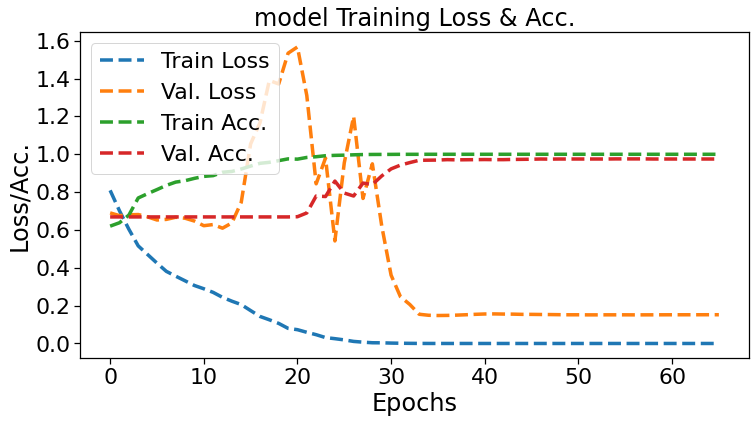

In [34]:
# define a plot function to plot history scores
def plot_history(history, title, save_path, figsize=(12, 6), font_scale=1, linewidth=3.5):
    with sns.plotting_context(
        "notebook", font_scale=2, rc={"lines.linewidth": linewidth}
    ):
        epochs = len(history.history["val_loss"])
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(title)
        ax.set_ylabel("Loss/Acc.")
        ax.set_xlabel("Epochs")
        sns.lineplot(history.history["loss"], label="Train Loss", ax=ax, linestyle='--')
        sns.lineplot(history.history["val_loss"], label="Val. Loss", ax=ax, linestyle='--')
        sns.lineplot(history.history["acc"], label="Train Acc.", ax=ax, linestyle='--')
        sns.lineplot(history.history["val_acc"], label="Val. Acc.", ax=ax, linestyle='--')
        fig.savefig(save_path)


# call plot function
plot_history(history, "model Training Loss & Acc.", "train_plot.png")

In [35]:
model.evaluate(testrmsprop_dataset)

NameError: name 'testrmsprop_dataset' is not defined

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import det_curve, DetCurveDisplay, roc_curve, RocCurveDisplay

In [ ]:
y_true, y_pred, y_score = [], [], []

for im, lb in tqdm(test_dataset):
    lb = np.argmax(lb, axis=-1)[0]
    scores = model.predict(im)[0]
    pred = np.argmax(scores)
    
    y_true.append(lb)
    y_pred.append(pred)
    y_score.append(scores[_bf_index])

In [ ]:
clf = classification_report(y_true=y_true, y_pred=y_pred, digits=4, target_names=_classes)

In [ ]:
print(clf)

In [ ]:
coded_y_score = np.clip(y_score, 0, 1)

In [ ]:
# fpr, fnr, thresholds = det_curve(y_true, coded_y_score, pos_label=_bf_index)
fpr, fnr, thresholds = det_curve(y_true, y_score, pos_label=_bf_index)
fig = DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name='DenseNet')
fig.plot()
plt.show()

In [ ]:
# fpr, fnr, thresholds = det_curve(y_true, coded_y_score, pos_label=_bf_index)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=_bf_index)
fig = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='DenseNet')
fig.plot()
plt.ylim([0.8, 1.0])
plt.plot([0, 1], 'r--')
plt.show()